In [34]:
import importlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import multiprocessing as mp
from pathlib import PurePath, Path
import pyarrow
import scipy.stats as stats
import time
import sys

# import plotnine as pn

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report, accuracy_score

from book_functions import *

importlib.reload(sys.modules['book_functions'])
# importlib.reload(sys.modules['sklearn'])

<module 'book_functions' from 'C:\\Users\\mlevy\\Workspace\\Advances-in-Financial-Machine-Learning\\book_functions.py'>

In [2]:
# 4.1
# Load data
data_f = PurePath('data/clean_IVE_ticks.parq')
df = pd.read_parquet(data_f)
print(df)

                        price     bid     ask   size      v            dv
dates                                                                    
2009-09-28 09:30:00   50.7900   50.70   50.79    100    100  5.079000e+03
2009-09-28 09:30:00   50.7100   50.70   50.79    638    638  3.235298e+04
2009-09-28 09:31:32   50.7500   50.75   50.76    100    100  5.075000e+03
2009-09-28 09:31:33   50.7500   50.72   50.75    100    100  5.075000e+03
2009-09-28 09:31:50   50.7500   50.73   50.76    300    300  1.522500e+04
2009-09-28 09:31:51   50.7500   50.74   50.76    300    300  1.522500e+04
2009-09-28 09:32:06   50.7800   50.76   50.78    300    300  1.523400e+04
2009-09-28 09:32:06   50.7800   50.76   50.78    500    500  2.539000e+04
2009-09-28 09:32:06   50.7800   50.76   50.78    100    100  5.078000e+03
2009-09-28 09:32:56   50.8226   50.81   50.83    100    100  5.082260e+03
2009-09-28 09:33:02   50.8100   50.80   50.81    500    500  2.540500e+04
2009-09-28 09:33:02   50.8100   50.80 

In [3]:
dol_df = compDollarBars(df, 'dv', 1_000_000)

In [4]:
close = dol_df.price.copy()
close = close[~close.index.duplicated()]

dailyVol = getDailyVol(close)
tEvents = getTEvents(close, h=dailyVol.mean())
t1 = addVerticalBarrier(tEvents, close)
ptSl = [1, 1]
trgt = dailyVol
minRet = .005
numThreads = 1

events = getEvents(close, tEvents, ptSl, trgt, minRet, numThreads, t1=t1)

C:\Users\mlevy\Workspace\Advances-in-Financial-Machine-Learning\book_functions.py:67: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  trgt = trgt.loc[tEvents]


In [5]:
# b
numCoEvents = mpPandasObj(mpNumCoEvents, ('molecule',events.index), numThreads, closeIdx=close.index, t1=events['t1'])
numCoEvents = numCoEvents.loc[~numCoEvents.index.duplicated(keep='last')]
numCoEvents = numCoEvents.reindex(close.index).fillna(0)

In [6]:
# c
# plot number of concurrent labels on primary axis, and exponentially weighted moving std of reutnrs on secondary
concurr_std_rets = pd.DataFrame().assign(concurr_count=numCoEvents.reset_index(drop=True), std=calcReturns(dol_df.price).ewm(50).std().reset_index(drop=True))

In [7]:
concurr_std_rets

,concurr_count,std
0,0.0,NaN
1,0.0,0.000969
2,0.0,0.001092
3,0.0,0.000910
4,0.0,0.001286
5,0.0,0.001148
6,0.0,0.001111
7,0.0,0.001076
8,0.0,0.001005
9,0.0,0.000990


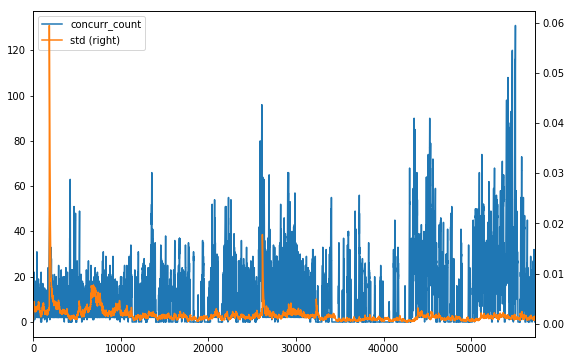

In [8]:
fig, ax = plt.subplots(figsize=(9,6))

concurr_std_rets.concurr_count.plot(legend=True, ax=ax)
concurr_std_rets['std'].plot(secondary_y=True, legend=True, ax=ax)

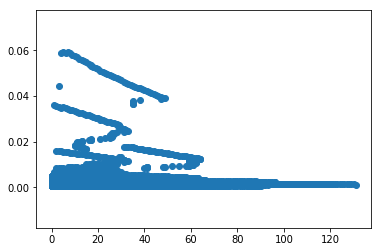

In [9]:
# d
plt.scatter(concurr_std_rets.concurr_count.values, concurr_std_rets['std'])

C:\Users\mlevy\Workspace\Advances-in-Financial-Machine-Learning\book_functions.py:67: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  trgt = trgt.loc[tEvents]


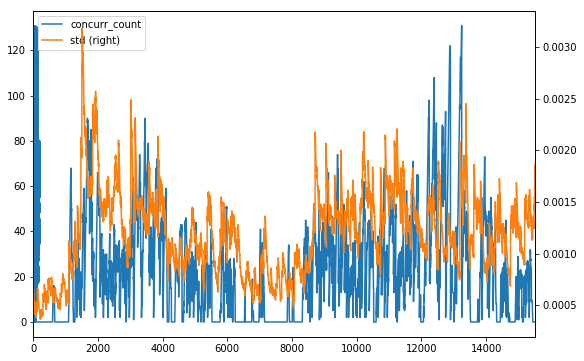

In [10]:
# Redo-ing 4.1 with subset of data
dol_df_2018 = dol_df['2018':]

close = dol_df_2018.price.copy()
close = close[~close.index.duplicated()]

dailyVol = getDailyVol(close)
tEvents = getTEvents(close, h=dailyVol.mean())
t1 = addVerticalBarrier(tEvents, close)
ptSl = [1, 1]
trgt = dailyVol
minRet = .005
numThreads = 1

events = getEvents(close, tEvents, ptSl, trgt, minRet, numThreads, t1=t1)

# b
numCoEvents = mpPandasObj(mpNumCoEvents, ('molecule',events.index), numThreads, closeIdx=close.index, t1=events['t1'])
numCoEvents = numCoEvents.loc[~numCoEvents.index.duplicated(keep='last')]
numCoEvents = numCoEvents.reindex(close.index).fillna(0)

# c
# plot number of concurrent labels on primary axis, and exponentially weighted moving std of reutnrs on secondary
concurr_std_rets = pd.DataFrame().assign(concurr_count=numCoEvents.reset_index(drop=True), std=calcReturns(dol_df_2018.price).ewm(50).std().reset_index(drop=True))

fig, ax = plt.subplots(figsize=(9,6))
concurr_std_rets.concurr_count.plot(legend=True, ax=ax)
concurr_std_rets['std'].plot(secondary_y=True, legend=True, ax=ax)

# d
plt.scatter(concurr_std_rets.concurr_count.values, concurr_std_rets['std'])

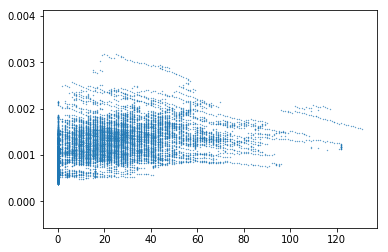

In [11]:
# d
plt.scatter(concurr_std_rets.concurr_count.values, concurr_std_rets['std'], s=.1)

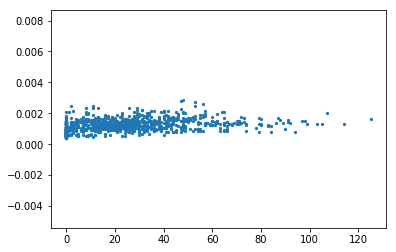

In [12]:
# sample 1000 rows
df_sample = concurr_std_rets.sample(1000)
plt.scatter(df_sample.concurr_count.values, df_sample['std'], s=5)

In [13]:
# 4.2
out = pd.DataFrame()
out['tW'] = mpPandasObj(mpSampleTW,('molecule',events.index),
                        numThreads, t1=events['t1'], numCoEvents=numCoEvents)

(array([1.572e+03, 2.736e+03, 2.300e+03, 1.259e+03, 7.530e+02, 3.740e+02,
        2.250e+02, 1.430e+02, 1.010e+02, 9.100e+01, 6.200e+01, 3.700e+01,
        2.400e+01, 2.600e+01, 2.200e+01, 1.600e+01, 1.000e+01, 4.000e+00,
        1.300e+01, 4.000e+00, 8.000e+00, 2.000e+00, 6.000e+00, 2.000e+00,
        0.000e+00, 3.000e+00, 1.000e+00, 3.000e+00, 3.000e+00, 2.000e+00,
        4.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([0.00766295, 0.01917636, 0.03068976, 0.04220317, 0.05371658,
        0.06522999, 0.07674339, 0.0882568 , 0.09977021, 0.11128362,
        0.12279702, 0.13431043, 0.14582384, 0.15733725, 0.16885066,
        0.18036406, 0.19187747, 0.20339088, 0.21490429, 0.22641769,
        0.2379311 , 0.24944451, 0.26095792, 0.27247133, 0.28398473,
        0.29549814, 0.30701155, 0.31

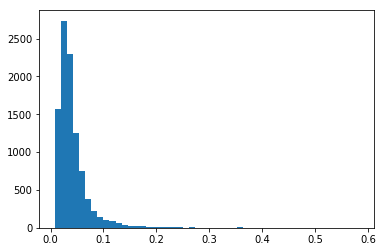

In [14]:
plt.hist(out['tW'], bins=50)

C:\Users\mlevy\Anaconda3\lib\site-packages\matplotlib\pyplot.py:935: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  return gcf().gca(**kwargs)


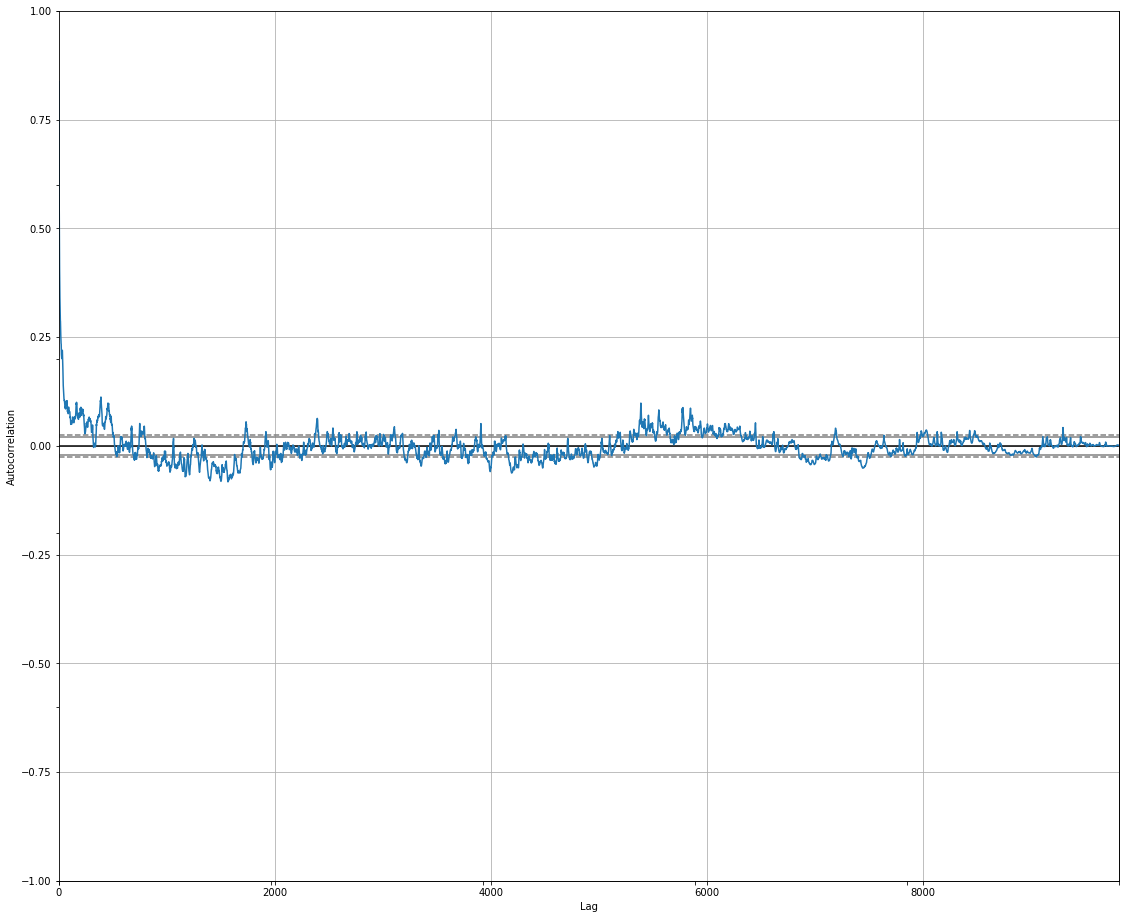

In [15]:
# AR(1) statistically significant as it's above the 95% and 99% confidence bands
out['tW'].autocorr()
fig, ax = plt.subplots(figsize=(19,16))
ax.set_xticklabels([])
ax.set_yticklabels([])
pd.plotting.autocorrelation_plot(out['tW'])

In [16]:
# 4.3
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_validate

xy = pd.DataFrame().assign(close=close, close_lag=close.shift(1)).dropna()

y = xy.loc[:,'close'].values
X = xy.loc[:,'close_lag'].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

n_estimator = 100
RANDOM_STATE = 123
# oob_score for out of bag
rf = RandomForestRegressor(n_estimators=n_estimator,
                           criterion='mse', oob_score=True,
                           random_state=RANDOM_STATE)
rf.fit(X_train, y_train)
# a
rf.oob_score_

0.9983858440078089

In [17]:
# b
rf = RandomForestRegressor(max_depth=1, n_estimators=n_estimator,
                           criterion='mse', oob_score=True,
                           random_state=RANDOM_STATE)
scores = cross_validate(rf, X, y=y, cv=5, return_estimator=True)
oob_scores = [est.oob_score_ for est in scores['estimator']]
oob_scores, np.mean(oob_scores)

([0.7026974495677875,
  0.7091069759700497,
  0.6637531442597111,
  0.5978587087676777,
  0.5852274128418766],
 0.6517287382814205)

In [18]:
# c
# Out of bag accuracy so much higher due to incorrect assumption of IID, as detailed all in ch.4
# For Random Forest, all the trees are too similar as they oversample redudanct sampels, which causes the bias
# Cross validation is less biased

In [19]:
# 4.4
def getTimeDecay(tW, clfLastW=1.):
    # apply piecewise-linear decay to observed uniqueness (tW)
    # newest observation gets weight=1, oldest observation gets weight=clfLastW
    clfW = tW.sort_index().cumsum()
    if clfLastW >= 0:
        slope = (1.-clfLastW)/clfW.iloc[-1]
    else:
        slope = 1./((clfLastW+1)*clfW.iloc[-1])
    const = 1.-slope*clfW.iloc[-1]
    clfW = const+slope*clfW
    clfW[clfW < 0] = 0
    print(const, slope)
    return clfW

1.0 0.0
0.75 0.0006145136595238856
0.5 0.0012290273190477712
1.1102230246251565e-16 0.0024580546380955424
-0.33333333333333326 0.00327740618412739
-0.9999999999999998 0.004916109276191085


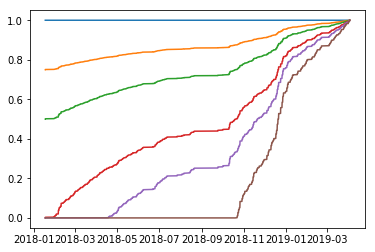

In [20]:
for i in [1, .75, .5, 0, -.25, -.5]:
    clfW = getTimeDecay(out['tW'], i)
    plt.plot(clfW)

In [21]:
def getExpTimeDecay(tW, clfLastW=1., exp=1.):
    # apply exponential decay to observed uniqueness (tW)
    # newest observation gets weight=1, oldest observation gets weight=clfLastW
    clfW = tW.sort_index().cumsum()
    if clfLastW >= 0:
        slope = ((1.-clfLastW)/clfW.iloc[-1])**exp
    else:
        slope = (1./((clfLastW+1)*clfW.iloc[-1]))**exp
    const = 1.-slope*clfW.iloc[-1]
    clfW = const+slope*clfW
    clfW[clfW < 0] = 0
    print(const, slope)
    return clfW

1.0 0.0
-0.5878414083038161 0.0039030009382413533
-1.6704202964681771 0.006564038995398077
-3.491093709041704 0.011039353721631673
-4.572578171089441 0.013697701619596377
-6.553089201003355 0.018565905942475654


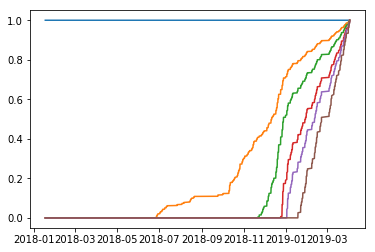

In [22]:
for i in [1, .75, .5, 0, -.25, -.5]:
    clfW = getExpTimeDecay(out['tW'], i, .75)
    plt.plot(clfW)

In [23]:
# 4.5
# TODO: answer questions

In [85]:
# 4.6

# from page 65-66
t1 = pd.Series([2,3,5],index=[0,2,4]) # index = time of feature observed, value is time of label determined
barIx  =range(t1.max()+1) # index of all bars
indM = getIndMatrix(barIx,t1)
indM  # binary matrix indicating which price bar influences the label for each observation

,0,1,2
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,0.0,1.0
5,0.0,0.0,1.0


In [89]:
# randomly select a number from our features (1, 2, 3)
phi = [1]  # example: we select feature2
# from snipper 4.5 seqBootstrap()
avgU = pd.Series()
for i in indM:
    indM_ = indM[phi+[i]] # reduce indM
    avgU.loc[i] = getAvgUniqueness(indM_).iloc[-1]

print('Average Uniqueness: \n',avgU)

Average Uniqueness: 
 0    0.833333
1    0.500000
2    1.000000
dtype: float64


In [91]:
# Updated probabilities for 2nd draw
# Shown in book as = {5/14, 3/14, 6/14}
# Feature3 has highest probability since no overlap with feature we just selected (feature2)
prob1 = avgU/avgU.sum()
print('Feature draw probabilities: \n', prob1)

Feature draw probabilities: 
 0    0.357143
1    0.214286
2    0.428571
dtype: float64


In [92]:
# In 2nd draw, we select feature3 i.e. phi[2]
phi = [1,2] 
# from snipper 4.5 seqBootstrap()
avgU = pd.Series()
for i in indM:
    indM_ = indM[phi+[i]] # reduce indM
    avgU.loc[i] = getAvgUniqueness(indM_).iloc[-1]
print('Average Uniqueness: \n',avgU)

Average Uniqueness: 
 0    0.833333
1    0.500000
2    0.500000
dtype: float64


In [96]:
# answer to 4.6
# Feature1 has greatest probability since it hasn't been selected yet i.e. less overlap
# prob for 3rd draw = {5/11, 3/11, 3/11}
prob2 = avgU/avgU.sum()
print('Feature draw probabilities: \n', prob2)

Feature draw probabilities: 
 0    0.454545
1    0.272727
2    0.272727
dtype: float64


In [101]:
# 4.7
t1 = pd.Series([2,3,5],index=[0,2,4]) # index = time of feature observed, value is time of label determined
barIx  =range(t1.max()+1) # index of all bars
indM = getIndMatrix(barIx,t1)

phi = [1]  # example: we select feature2
# from snipper 4.5 seqBootstrap()
avgU = pd.Series()
for i in indM:
    indM_ = indM[phi+[i]] # reduce indM
    avgU.loc[i] = getAvgUniqueness(indM_).iloc[-1]

# print('Average Uniqueness: \n',avgU)

# Updated probabilities for 2nd draw
# Shown in book as = {5/14, 3/14, 6/14}
# Feature3 has highest probability since no overlap with feature we just selected (feature2)
prob1 = avgU/avgU.sum()
print('Feature draw probabilities: \n', prob1)

# In 2nd draw, we select feature2 again
phi = [1, 1] 
# from snipper 4.5 seqBootstrap()
avgU = pd.Series()
for i in indM:
    indM_ = indM[phi+[i]] # reduce indM
    avgU.loc[i] = getAvgUniqueness(indM_).iloc[-1]
# print('Average Uniqueness: \n',avgU)

# Feature3 again has even greater probability than before since still no overlap
# prob for 3rd draw = {7/19, 3/19, 9/19}
prob2 = avgU/avgU.sum()
print('Feature draw probabilities: \n', prob2)

Feature draw probabilities: 
 0    0.357143
1    0.214286
2    0.428571
dtype: float64
Feature draw probabilities: 
 0    0.368421
1    0.157895
2    0.473684
dtype: float64
